# Introduction

Hello, nice to meet you!   
We are *"snack for a friend"* - A non-profit organization that donates candy and snacks to children from needy families every week. There is no doubt that a donation of nutritious food is important, but there is nothing like something sweet to make a human heart happy.    
We believe that snacks and sweets often boost the mood and are a comforting place on a difficult day. But at the same time it is important for us to keep the children healthy. Therefore, we hired Aviv and Elad to help us find the ultimate snacks for our children! 
We provided them tables with a lot of data on the various snacks available to us. We like Aviv and Elad to recommend us on the 3 top snacks in each category (Candy, Cookies & Biscuits, Cakes, Chips & Pretzels, Chocolate, Popcorn & Peanuts & Seeds) by considering the following requirements:

1. A snack that is the least harmful to health (in terms of Carbs, Sugars and Fats)
2. A candy that contains relatively many vitamins.
3. A snack with a wrapper as colorful and eye-catching as possible for children.
4. A recommendation for one candy that is suitable for the sensitivity of peanuts/nuts
5. Nice to have - recommendation of products from the same brand to reduce purchase costs.

It is important to note that we put the health consideration at the top of our priorities! therefore, In our choices, it will take precedence over the colors and beauty of the snack wrapper

In [1]:
#!pip install opencv-python
#!pip install nltk
#!pip install imutils
#import nltk  
#import cv2
#nltk.download('stopwords')

In [2]:
import argparse
from collections import defaultdict, Counter
import cv2
from fuzzywuzzy import fuzz
import imutils
from imutils import build_montages, paths
from itertools import combinations # not mandatory
import itertools
import os
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import string

/Users/aburshtein/anaconda3/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Define useful functions for cleaning the data

In [3]:
def remove_parentheses(string):
    pattern = r'\([^()]*\)'  # Matches "(...)" pattern
    while re.search(pattern, string):
        string = re.sub(pattern, '', string)
    return string.strip()

def format_ingredients(string):
    string = string.replace('.', '')  # Remove periods
    string = re.sub(r'\s*,\s*', ',', string)  # Remove spaces after commas
    ingredients_list = string.split(',')  # Split by comma
    formatted_ingredients = [ingredient.strip() for ingredient in ingredients_list]  # Remove leading/trailing spaces for each ingredient
    return ', '.join(formatted_ingredients)  # Join formatted ingredients with commas

def clean_text_values(df):
    text_columns = df.select_dtypes(exclude=[np.number]).columns
    for column in text_columns:
        if column == 'category':
            continue
        df[column].fillna('NA', inplace=True)
        df[column] = df[column].map(str.lower)
        if column == 'ingredients':
            df[column] = df[column].apply(remove_parentheses)
            df[column] = df[column].apply(format_ingredients)
        if column == 'household_serving_fulltext':
            df[column] = df[column].map(lambda x: re.sub('[^a-z]+', '', x))
    return df

### Read the data


In [4]:
df = pd.read_csv('data/food_train.csv')
food_test = pd.read_csv('data/food_test.csv')
food_nutrients = pd.read_csv('data/food_nutrients.csv')
nutrients_names = pd.read_csv('data/nutrients.csv')

In [5]:
clean_text_values(df)
nutrients = pd.merge(food_nutrients, nutrients_names, how='left',on='nutrient_id')
pivoted_nutrients = pd.pivot_table(nutrients, values='amount', index='idx', columns='name')
data = pd.merge(df, pivoted_nutrients, how='left', on='idx')

data.head(3)


,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,"Alcohol, ethyl",Biotin,...,"Vitamin A, IU",Vitamin B-12,Vitamin B-6,"Vitamin C, total ascorbic acid","Vitamin D (D2 + D3), International Units",Vitamin E,Vitamin E (alpha-tocopherol),Vitamin K (phylloquinone),Xylitol,"Zinc, Zn"
0,1,brix chocolate,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,onz,chocolate,NaN,NaN,...,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour, margarin...",38.0,g,cookie,cookies_biscuits,NaN,NaN,...,526.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour, margarin...",30.0,g,cookies,cookies_biscuits,NaN,NaN,...,667.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Enum

In [6]:
CANDY = 'candy'
COOKIES = 'cookies_biscuits'
CAKES = 'cakes_cupcakes_snack_cakes'
CHIPS_PRETZELS = 'chips_pretzels_snacks'
CHOCOLATE = 'chocolate'
POPCORN_PEANUTS = 'popcorn_peanuts_seeds_related_snacks'

In [7]:
def data_by_category(df, category):
    return df[df['category'] == category]

## Part 1 & 2 - Vitamins VS Calories, Carbs, Sugars and Fats

### Distribution of calories & fats & sugars & carbohydrates across Categories

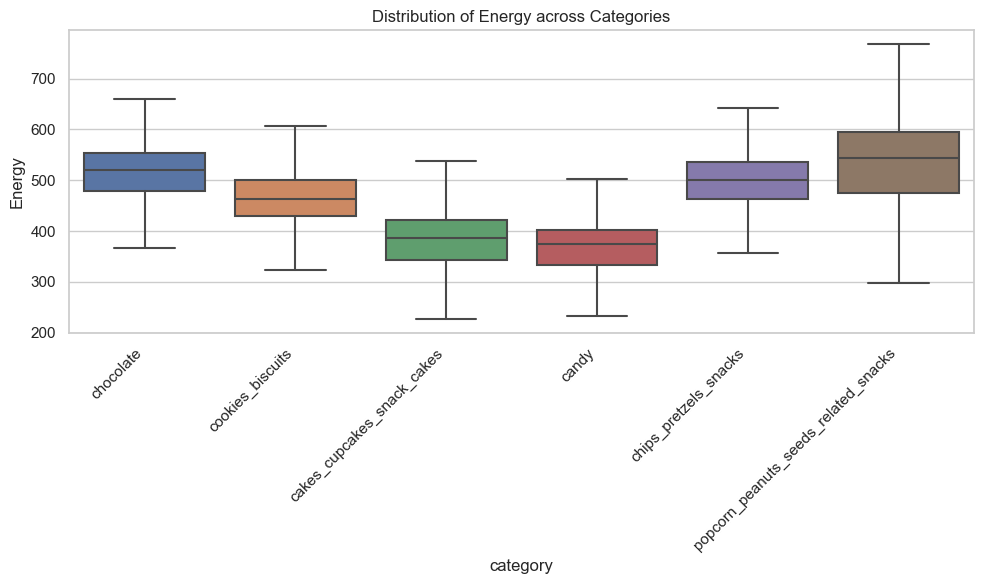

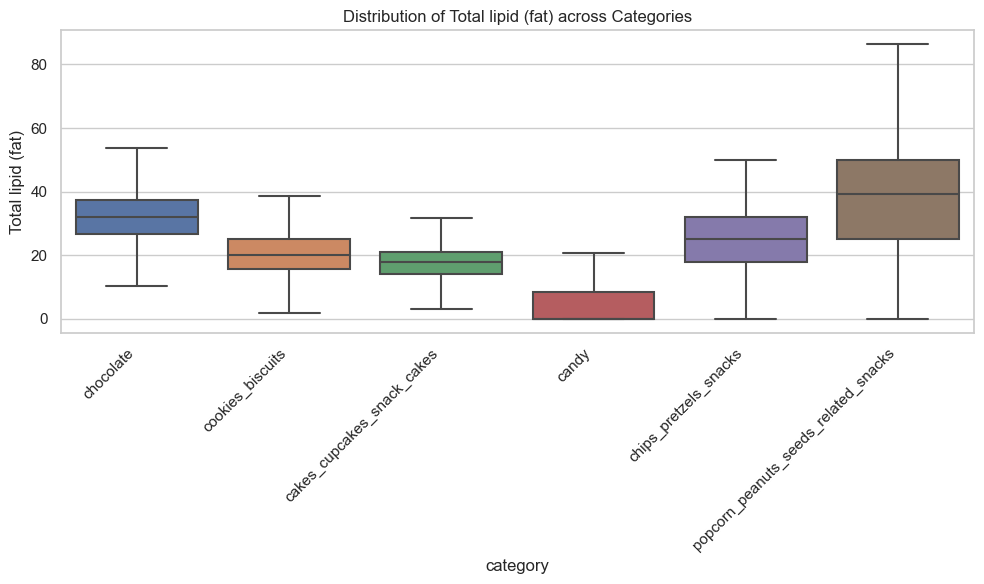

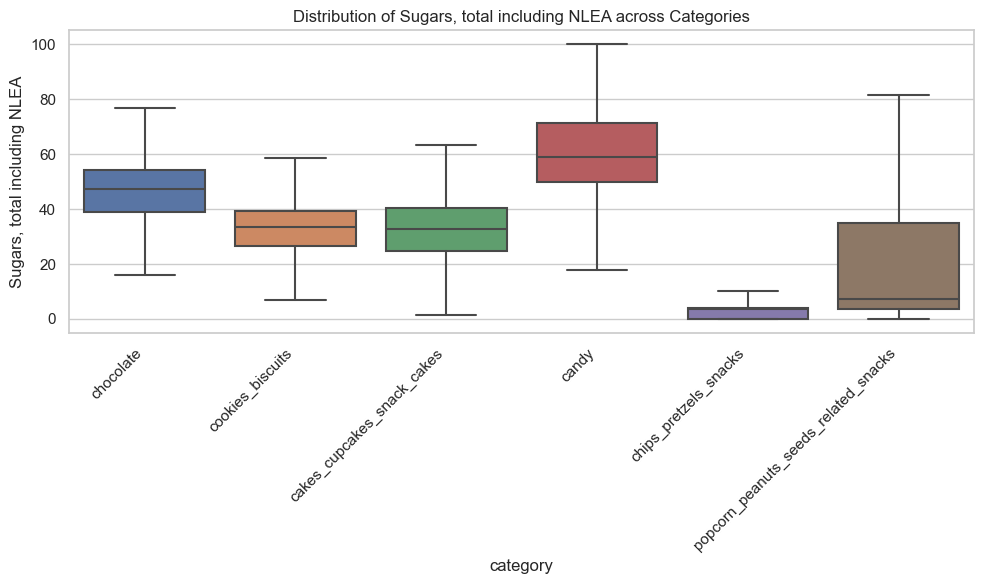

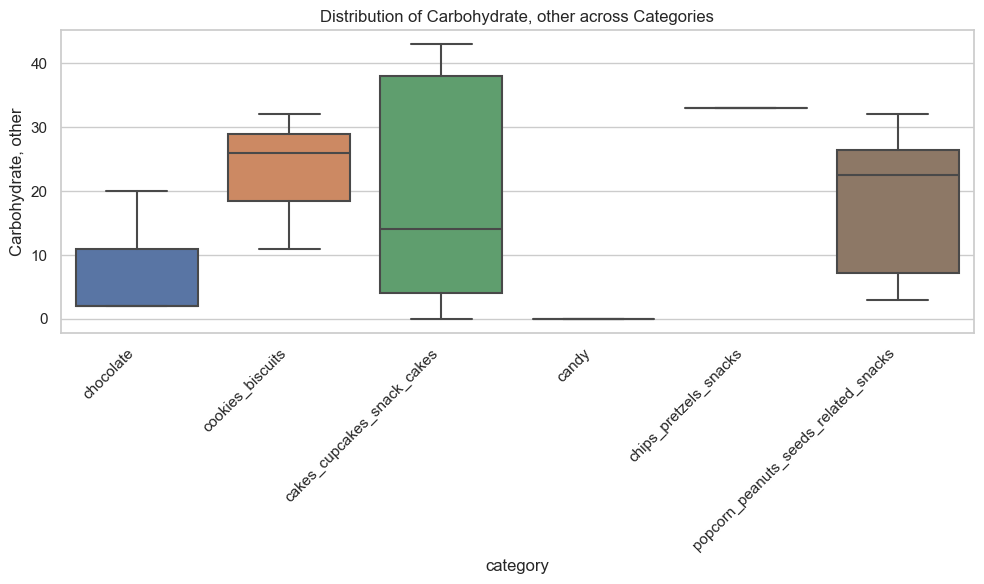

In [8]:
# Set Seaborn theme
sns.set_theme(style="whitegrid")

# Plotting for each fat-related column
fat_columns = ['Energy' ,'Total lipid (fat)', 'Sugars, total including NLEA', 'Carbohydrate, other']
for fat_col in fat_columns:
    plt.figure(figsize=(10, 6))
    plt.title(f"Distribution of {fat_col} across Categories")
    plt.xlabel("Category")
    plt.ylabel(f"{fat_col}")
    sns.boxplot(x='category', y=fat_col, data=data, showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

As you can see, products from Candy category have the lowest sum of Energy and Fat but the highest some of Sugars.
Moreover, products from Popcorn & Peanuts category have the highest sum of Energe and Fat, low some of Sugars and quite a few Carbohydrates.
In addition, Cakes have a wide range of products with different amounts of Carbohydrates, and Chips' products have the lowest amount of Sugars.

## Vitamins score VS Unhealthy score

We create 2 new columns: 
- Vitamins score - Contains the sum of all the amounts of vitamins found in the data for each snack.
- Unhealthy score - Contains the sum of all the amounts of Calories, Carbs, Sugars, Fats and unhealthy ingredients found in the data for each snack.

We are aware that there is a difference between the units of measure, but this doesn't affect the calculation of the score.

We will look for the top 5 snacks in each category that will have on the one hand, the highest vitamins score and on the other hand, the lowest unhealthy score. After that we wil focus on those top 5 snackes in each category and look over the color of the snack's wrapper. 

We would like to choose the snackes with the most colorful wrapper, but we would like to emphasize that the issue of health is of the utmost importance for us, therefore the color of the wrapper is only for the purpose of recommendation. 
Finally, we will make an informed choice of the 3 best snacks from each category.

In the paper work we choose to show one chosen category for example. The information extraction work of the rest categories is attached in the jupyter notebook "Exploratory Data Analysis".

In [9]:
unhealthy_columns = ['Sugars, total including NLEA','Cholesterol','Xylitol','Fatty acids, total monounsaturated',
      'Fatty acids, total polyunsaturated', 'Fatty acids, total saturated','Fatty acids, total trans', 'Carbohydrate, by difference', 
                     'Carbohydrate, other']
data['sum_of_unhealthy'] = data.loc[:,unhealthy_columns].sum(axis=1)

In [10]:
vitamins_columns = ['Biotin','Calcium, Ca','Fiber, total dietary','Folate, total','Iodine, I','Iron, Fe', 'Magnesium, Mg', 'Manganese, Mn','Niacin','Pantothenic acid',
            'Phosphorus, P','Potassium, K','Riboflavin','Selenium, Se','Thiamin','Vitamin A, IU','Vitamin B-12', 'Vitamin B-6', 'Vitamin C, total ascorbic acid',
            'Vitamin D (D2 + D3), International Units', 'Vitamin E','Vitamin E (alpha-tocopherol)', 'Vitamin K (phylloquinone)']

data['sum_of_vitamins'] = data.loc[:,vitamins_columns].sum(axis=1)

[גרף על כל הקטגוריות שמציג עקומה של שויטמינים אל מול השומנים, בצבעים שונים]

/Users/aburshtein/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/aburshtein/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/aburshtein/anaconda3/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/Users/aburshtein/anaconda3/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


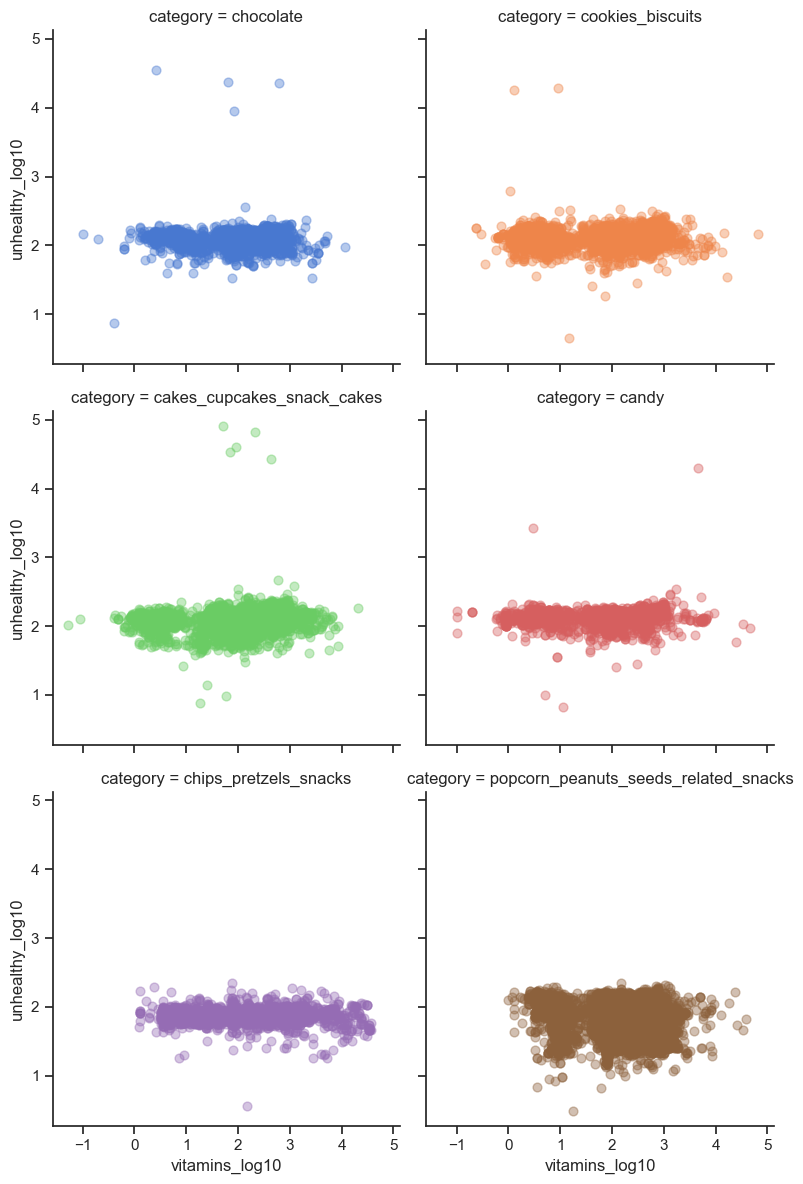

In [11]:
data['vitamins_log10'] = np.log10(data['sum_of_vitamins'])
data['unhealthy_log10'] = np.log10(data['sum_of_unhealthy'])

sns.set_theme(style="ticks")

# Show the results of a linear regression within each dataset
sns.lmplot(
    data=data, x="vitamins_log10", y="unhealthy_log10", col="category", hue="category",
    col_wrap=2, palette="muted", ci=None,
    height=4, scatter_kws={"s": 40, "alpha": 0.4})

[Add Explanation]

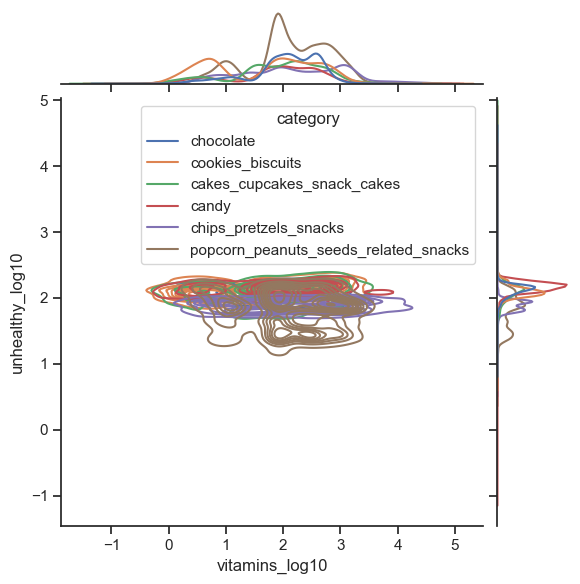

In [12]:
sns.set_theme(style="ticks")

g = sns.jointplot(data=data,
    x="vitamins_log10", y="unhealthy_log10", hue="category",
    kind="kde")

[Add Explanation]

## Scatter plot - Vitamins score VS Calories, Carbs, Sugars and Fats score

1. At firt, we removed rows with at least 1 Nan in 'sum_of_vitamins','sum_of_unhealthy' columns. (We prefer to look at products with all available information. We are aware that as a result our choice is reduced but we must be sure that the top product we recommend absolutely reflects the demands of the consumers).
2. Sorting the values in each selected column and choose the top 10 indexes (min/max in accordance).
3. Find the vitamins score and unhealthy score for each index (20 pairs in total).
3. Create Scatter plot for the top 20 in each category. The vitamins score is in x axis, the unhealthy score is in y axis.

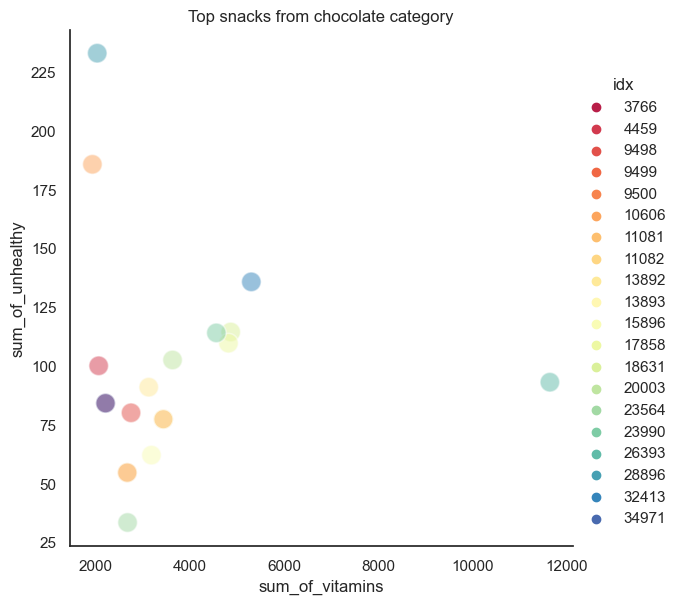

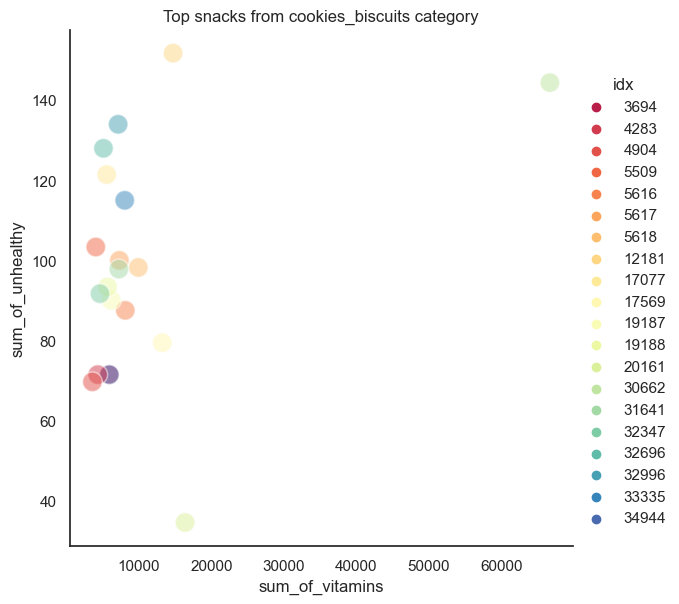

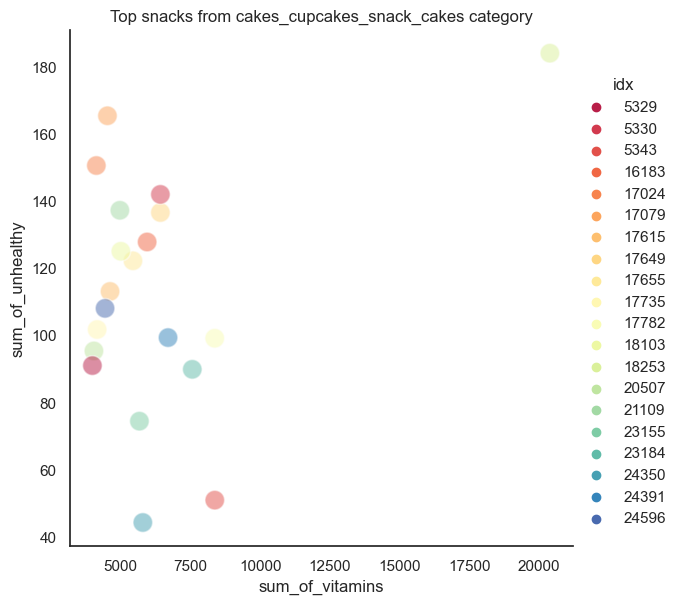

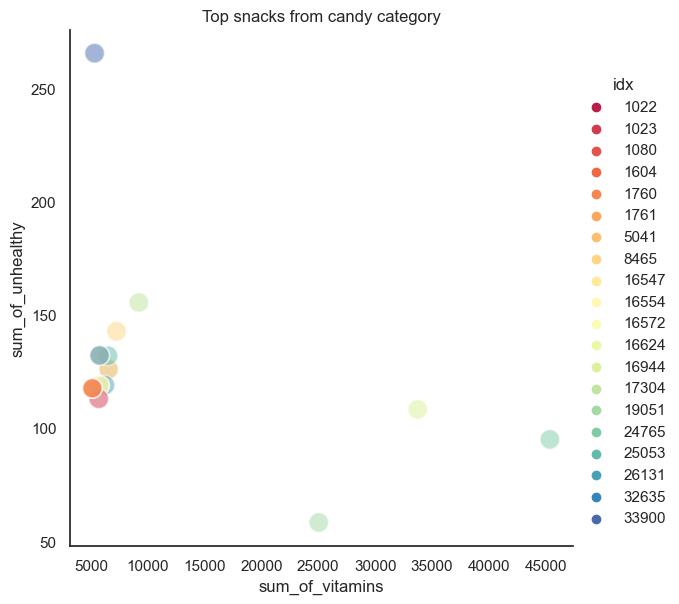

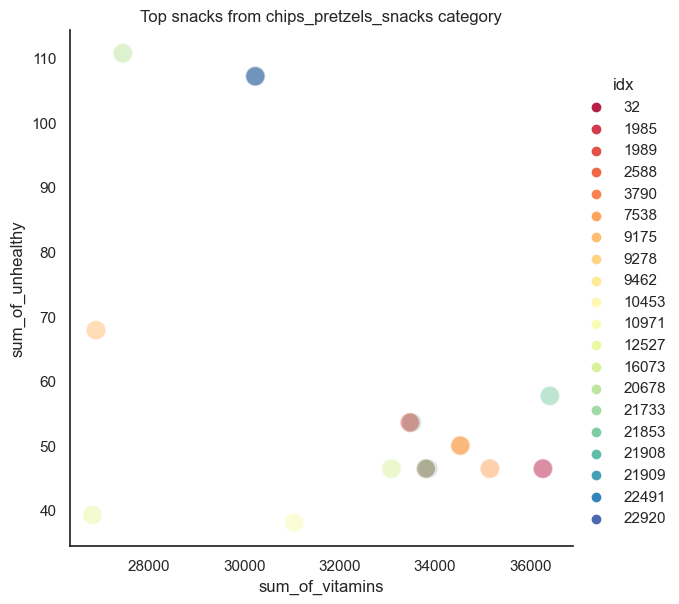

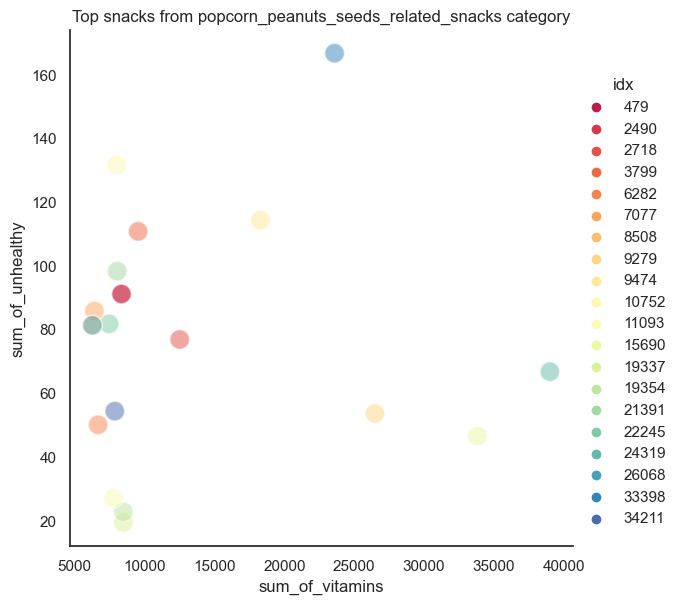

In [13]:
def scatter_plot(df, category, size=None):
    sns.set_theme(style="white")
    top20 = df.dropna(subset=['sum_of_vitamins','sum_of_unhealthy']).sort_values(by=['sum_of_vitamins','sum_of_unhealthy'],ascending=[False,True]).head(20)#.drop(22140)
    sns.relplot(x="sum_of_vitamins", y="sum_of_unhealthy",hue='idx', s = 200,
            sizes=(40, 400), alpha=.5, palette=sns.color_palette("Spectral", 20), size = size,
            height=6, data=top20).set(title=f"Top snacks from {category} category")
        
for category in data['category'].unique():
    scatter_plot(data_by_category(data, category), category)

### Selected Top 5 snacks from each category

As we said in the intreduction, we prefer snacks that have more vitamins and are less harmful. Therefore, snacks that show in the right bottom area are the most recommended and snacks that show in the left top area are unrecommended.

In [14]:
top5_chocolate_idx = [26393, 23564, 11081, 15896, 11082]
top5_cookies_idx = [3694, 20161, 4283, 4904, 34944]
top5_cake_idx = [24350, 5343, 23155, 23184, 17782]
top5_candy_idx = [19051, 1760, 24765, 1761, 16944]
top5_chips_pretzele_idx = [21853, 32, 7538, 21733, 3790]
top5_popcorn_peanuts_idx = [9279,24319,15690,11093,19337]

## Part 3 - Colorful Wrapper

As we told in the Introduction, besides supplying the least toxic food we shall also consider the colorfulnees of the wrap in order to makes the kids happy :)

There are many ways to define a "score" of colorfulness, we chose 'Hasler and Süsstrunk, 2003' way.

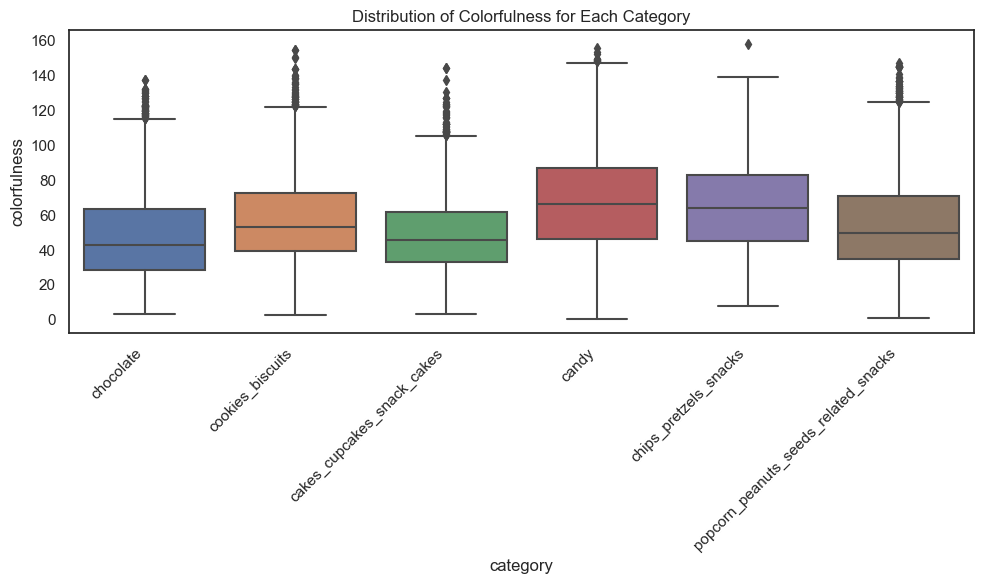

In [15]:
def image_colorfulness(image):
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(image.astype("float"))
    # compute rg = R - G
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

def colorfulness(row):
    category = row['category']
    idx = row['idx']
    image_path = f"images/train/{category}/{idx}.jpg"
    image = cv2.imread(image_path)
    colorfulness = round(image_colorfulness(image),3)
    return colorfulness

data['colorfulness'] = data.apply(colorfulness, axis=1)

# Plotting the distribution of colorfulness for each category using boxplot
plt.figure(figsize=(10, 6))
plt.title("Distribution of Colorfulness for Each Category")
plt.xlabel("Category")
plt.ylabel("Colorfulness")
sns.boxplot(x='category', y='colorfulness', data=data)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Its semms like canddies have the most colorful wrapper.  
To be honest, that's also what we guessed was happening:).

### Scatter plot - Vitamins score VS Unhealthy score - The bigger the circle the more colorful snack wrapper 

In [16]:
top5_chocolate = data[data['idx'].isin(top5_chocolate_idx)]
top5_cookies = data[data['idx'].isin(top5_cookies_idx)]
top5_cake = data[data['idx'].isin(top5_cake_idx)]
top5_candy = data[data['idx'].isin(top5_candy_idx)]
top5_chips_pretzele = data[data['idx'].isin(top5_chips_pretzele_idx)]
top5_popcorn_peanuts = data[data['idx'].isin(top5_popcorn_peanuts_idx)]

In [17]:
def colorfulness_plot(df, category):
    sns.set_theme(style="white")
    sns.relplot(x="sum_of_vitamins", y="sum_of_unhealthy",hue='idx', size="colorfulness",
                sizes=(40, 400), alpha=.5, palette="muted",
                height=6, data=df).set(title=f"Colorfulness of snacks' wrapper - {category} category")

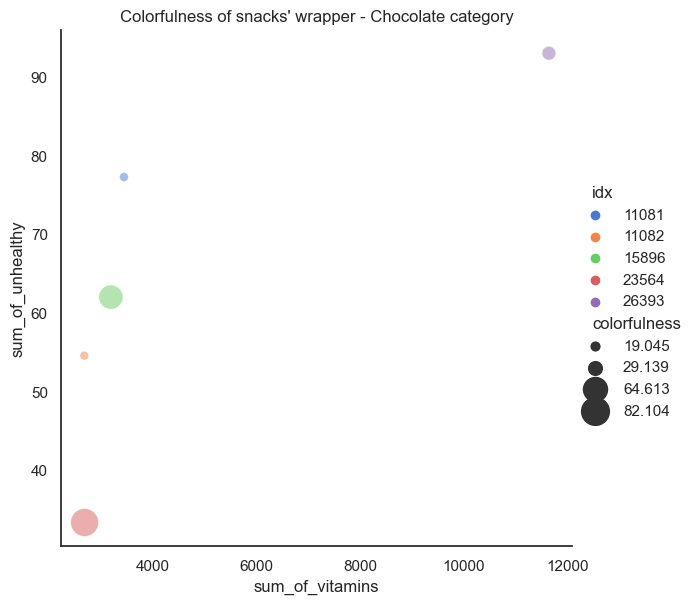

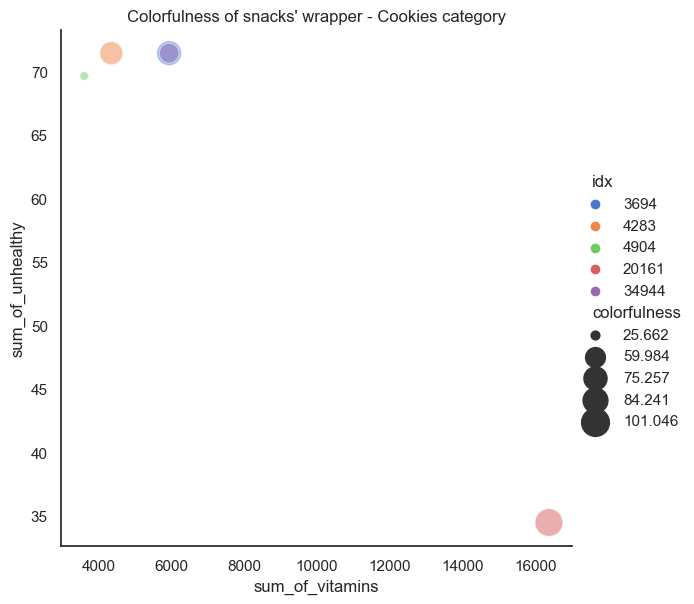

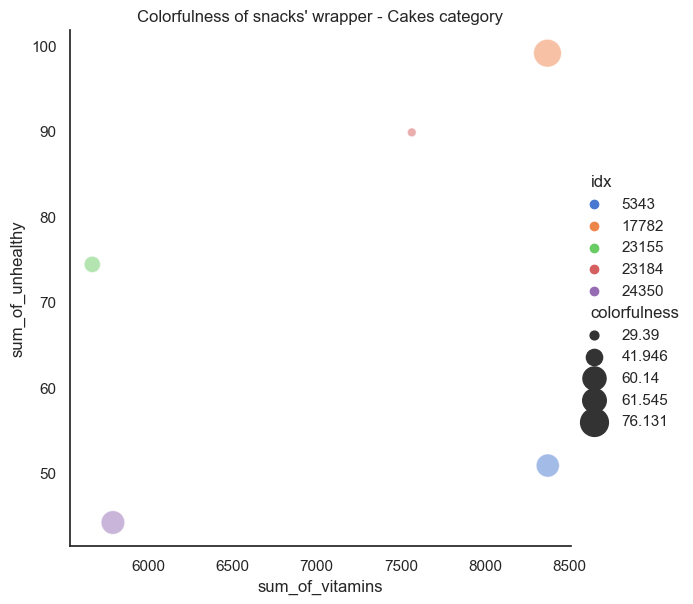

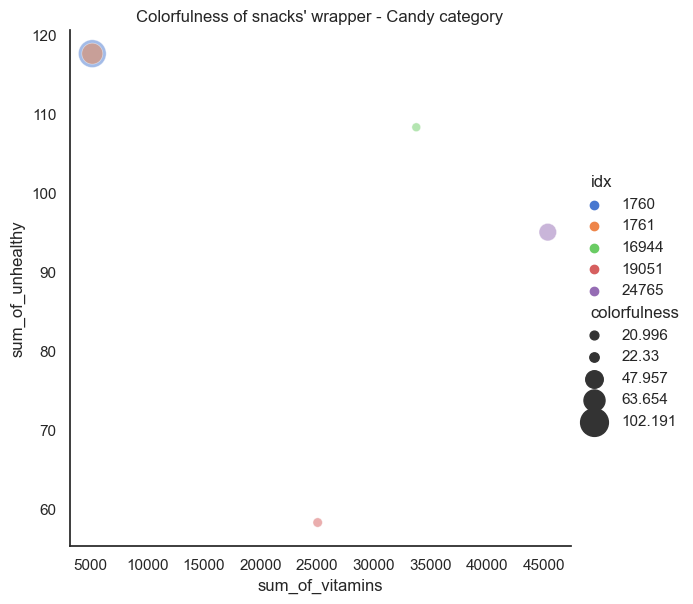

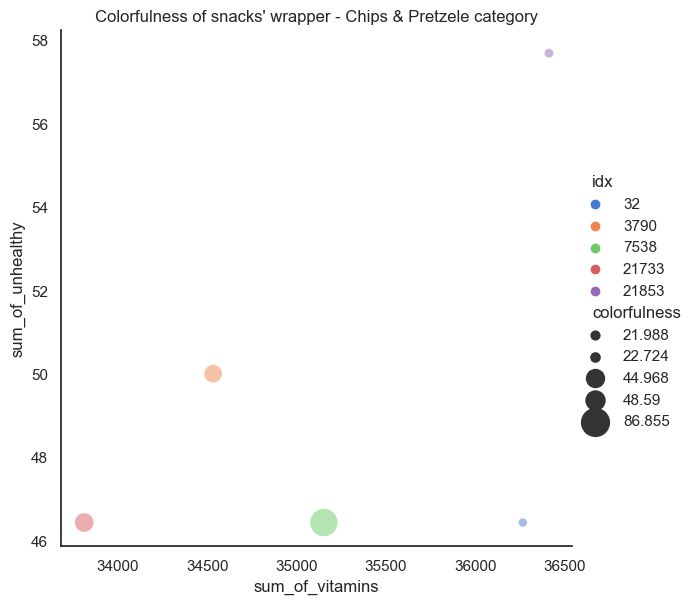

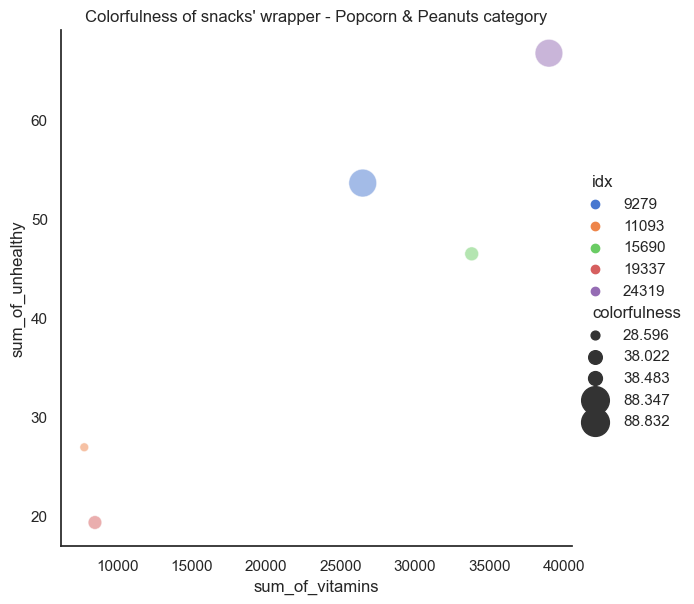

In [18]:
all_top5 = [[top5_chocolate, 'Chocolate'], [top5_cookies, 'Cookies'], [top5_cake, 'Cakes'], [top5_candy, 'Candy'], 
            [top5_chips_pretzele, 'Chips & Pretzele'], [top5_popcorn_peanuts, 'Popcorn & Peanuts']]
for item in all_top5:
    colorfulness_plot(item[0], item[1])

After looking at the color of the wrapper, we used it to make an informed choice for the 3 most recommended snacks from each category, taking health considerations into account.

In [19]:
top3_chocolate = [15896, 23564, 26393]
top3_cookies = [20161, 3694, 34944]
top3_cake = [5343, 24350, 23155]
top3_candy = [19051, 24765, 16944]
top3_chips_pretzele = [21733, 7538, 32]
top3_popcorn_peanuts = [19337, 9279, 15690]

[Add Selected photo]

## Part 4 - Sensitivity of Milk/Gluten/Peanut

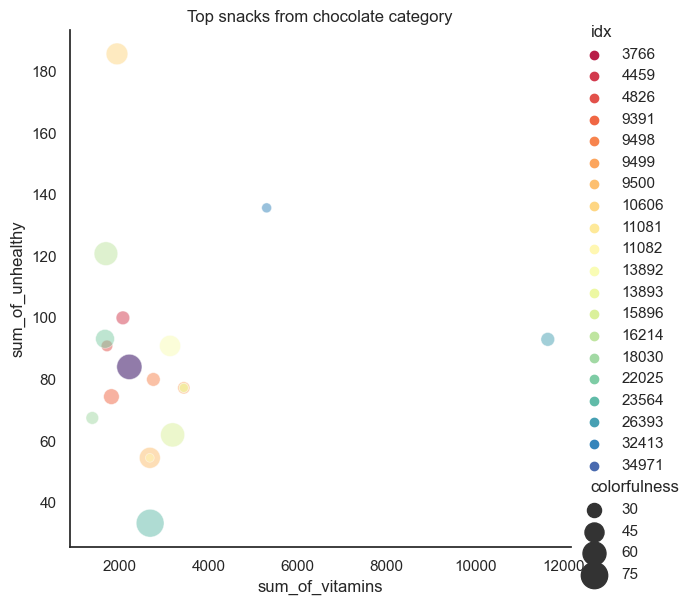

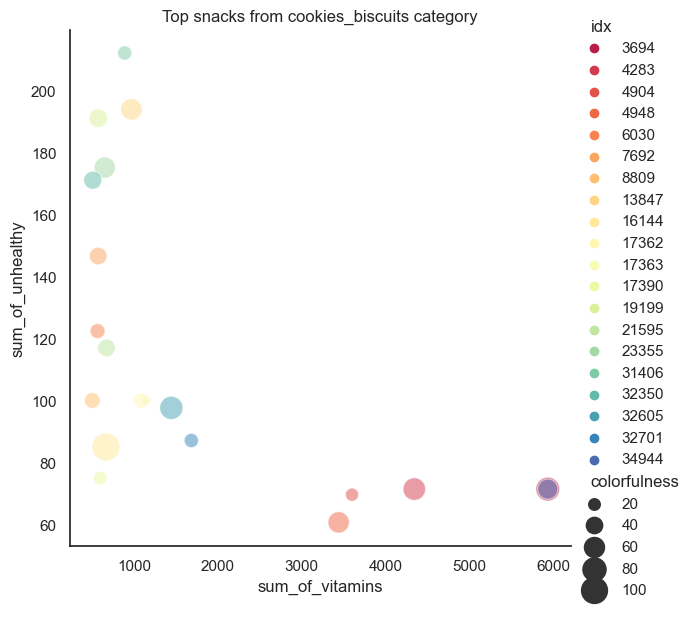

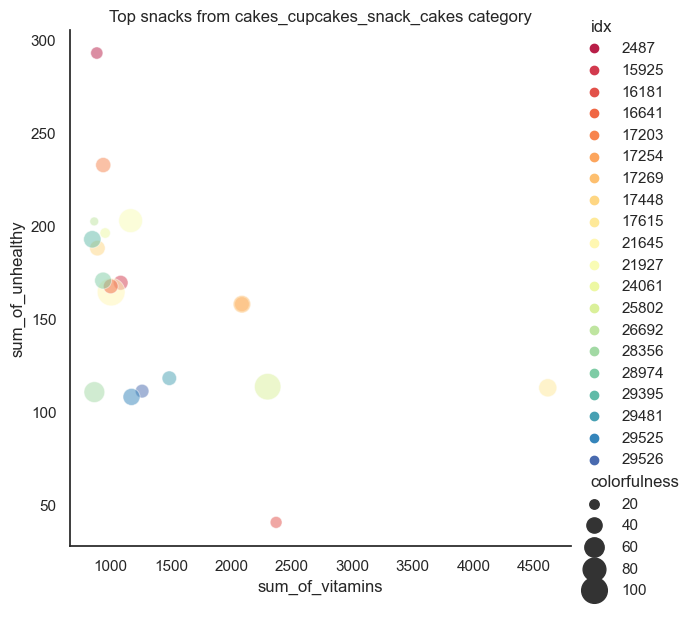

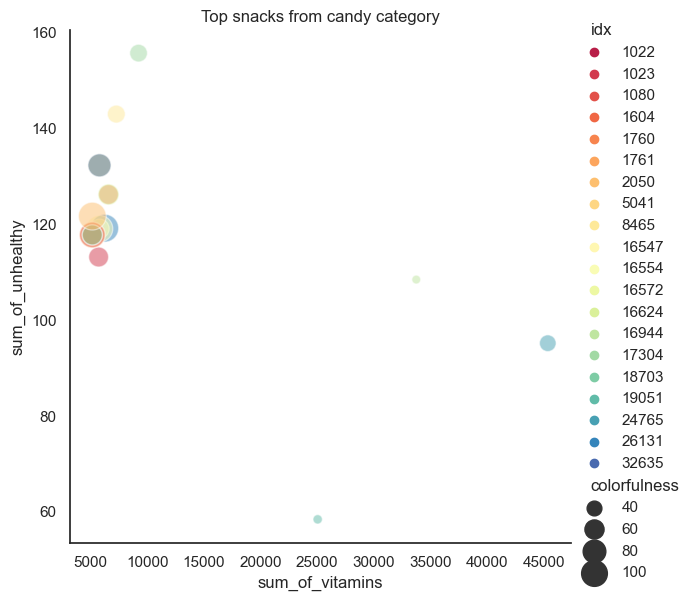

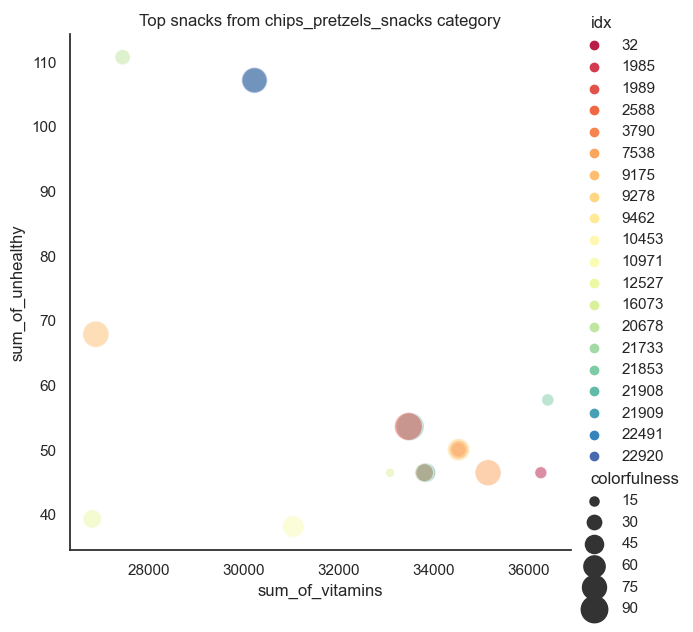

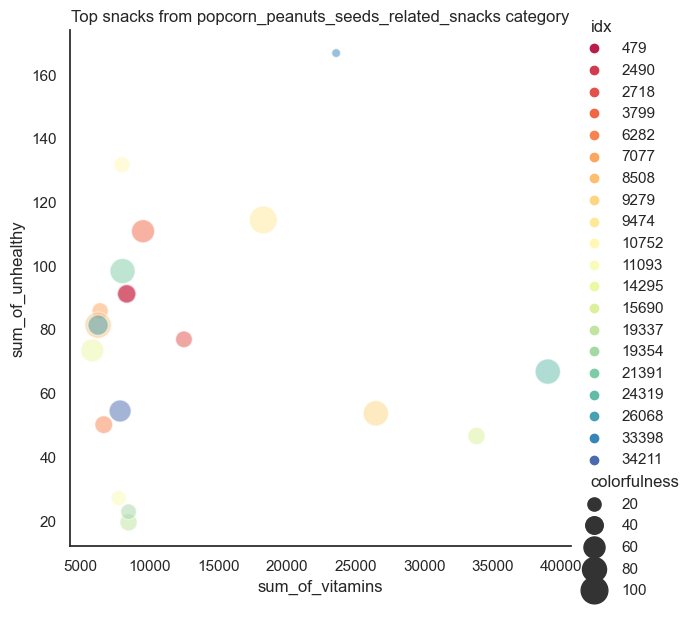

In [20]:
data['contains_allergies'] = data['ingredients'].map(lambda x: ('milk' in x) or ('flour' in x) or 
                                                     ('wheat' in x) or ('peanut' in x))
snacks_for_sensitive = data[data['contains_allergies'] == False]

for category in data['category'].unique():
    scatter_plot(data_by_category(snacks_for_sensitive, category), category, 'colorfulness')


We have chosen from each category the most recommended snack taking sensitivity & health & colorfulness considerations into account.

In [21]:
chocolate_snack_for_sensitive = 26393
cookies_snack_for_sensitive = 3694
cake_snack_for_sensitive = 17615 
candy_snack_for_sensitive = 24765
chips_pretzele_snack_for_sensitive = 7538
popcorn_peanuts_snack_for_sensitive = 24319

## Part 5 - Products from the Same Brand

#### Each idx is a node, Nodes are connected with edges if they are sharing the same brand  , We are looking for the most connected(dense) graph  
[Need to Edit!] 

In [22]:
d = dict()
all_top5_idx = [top5_cake_idx,top5_candy_idx,top5_chips_pretzele_idx,top5_chocolate_idx,top5_cookies_idx,top5_popcorn_peanuts_idx]

In [23]:
combi_6 = list(itertools.product(*all_top5_idx))
for combi in combi_6:
    combi_2 = list(itertools.combinations(combi, 2))
    A = nx.Graph()
    edges = list()
    A.add_nodes_from(combi)
    for combin in combi_2:
        brand1 = data[data['idx'] == combin[0]]['brand'].values[0]
        brand2 = data[data['idx'] == combin[1]]['brand'].values[0]
        if brand1 == brand2:
            edges.append(combin)
    A.add_edges_from(edges)
    d[combi] = nx.density(A)

In [24]:
max_value = max(d, key=d.get)

0.06666666666666667
number of nodes: 6
number of edges: 1
The edges are: [(21853, 9279)]


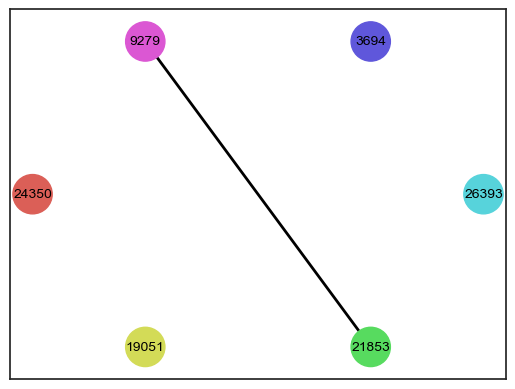

In [81]:
def print_network_info(G):
    print('number of nodes: %d' % G.number_of_nodes())
    print('number of edges: %d' % G.number_of_edges())
    
best_6 = list(max_value)
combi_2 = list(itertools.combinations(best_6, 2))
A = nx.Graph()
edges = list()
A.add_nodes_from(best_6)
for comb in combi_2:
    brand1 = data[data['idx'] == comb[0]]['brand'].values[0]
    brand2 = data[data['idx'] == comb[1]]['brand'].values[0]
    if brand1 == brand2:
        edges.append(comb)
A.add_edges_from(edges)

print(nx.density(A))
print_network_info(A)
print("The edges are:",edges)
nx.draw_networkx(A, pos=nx.shell_layout(A), node_size=800, node_color=sns.color_palette("hls", 6), font_size=10, font_color="black",
    edge_color="black", width=2)
plt.show()

In [45]:
for node in A.nodes:
    category = data[data['idx']==node]['category'].values[0]
    print(f'{node} - snack from {category} catgegory')

24350 - snack from cakes_cupcakes_snack_cakes catgegory
19051 - snack from candy catgegory
21853 - snack from chips_pretzels_snacks catgegory
26393 - snack from chocolate catgegory
3694 - snack from cookies_biscuits catgegory
9279 - snack from popcorn_peanuts_seeds_related_snacks catgegory


It seems that snack 21853 from chips & pretzels category and snack 9279 from popcorn & peanuts have the same brand!

In [98]:
print(data[data['idx']==21853]['brand'].values[0])
print(data[data['idx']==21853]['brand'].values[0]==data[data['idx']==9279]['brand'].values[0])

brad's raw chips
True


0.032679738562091505
number of nodes: 18
number of edges: 5
The edges are: [(3694, 34944), (19051, 16944), (21733, 9279), (21733, 15690), (9279, 15690)]


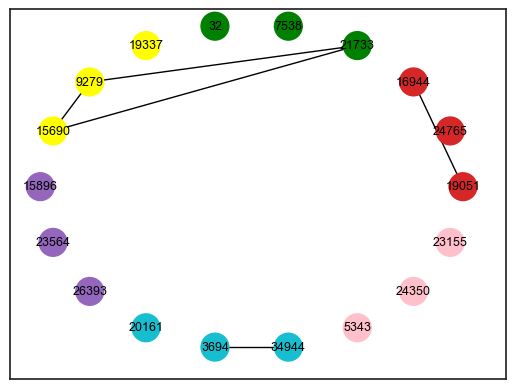

In [107]:
all_top3_idx = top3_chocolate + top3_cookies + top3_cake + top3_candy + top3_chips_pretzele + top3_popcorn_peanuts

combi_2 = combinations(all_top3_idx, 2)
B = nx.Graph()
edges = list()
B.add_nodes_from(all_top3_idx)
for combi in combi_2:
    brand1 = data[data['idx'] == combi[0]]['brand'].values[0]
    brand2 = data[data['idx'] == combi[1]]['brand'].values[0]
    if brand1 == brand2:
        edges.append(combi)
B.add_edges_from(edges)

color_map = []
for node in B:
    category = data[data['idx']==node]['category'].values[0]
    if category == CANDY:
        color_map.append('tab:red')
    elif category == COOKIES:
        color_map.append('tab:cyan')
    elif category == CAKES:
        color_map.append('pink')
    elif category == CHIPS_PRETZELS:
        color_map.append('green')
    elif category == CHOCOLATE:
        color_map.append('tab:purple')
    elif category == POPCORN_PEANUTS:
        color_map.append('yellow')
        
#node_color=sns.color_palette("hls", 18)
print(nx.density(B))
print_network_info(B)
print("The edges are:",edges)
nx.draw_networkx(B, pos=nx.shell_layout(B), node_size=400, node_color=color_map, font_size=9, font_color="black",
    edge_color="black", width=1)

plt.show()

In [112]:
brand = data[data['idx']==15690]['brand'].values[0]
print(f'It seems that snackes 15690 & 9279 from Popcorn & Peanuts category and snack 21733 from Chips & Pretzels category are from "{brand}" brand.')
print(data[data['idx']==15690]['brand'].values[0]==data[data['idx']==9279]['brand'].values[0]==data[data['idx']==21733]['brand'].values[0])

It seems that snackes 15690 & 9279 from Popcorn & Peanuts category and snack 21733 from Chips & Pretzels category are from "brad's raw chips" brand.
True


In [115]:
brand = data[data['idx']==16944]['brand'].values[0]
print(f'It seems that snackes 16944 & 19051 from Candy category are from "{brand}" brand.')
print(data[data['idx']==16944]['brand'].values[0]==data[data['idx']==19051]['brand'].values[0])

It seems that snackes 16944 & 19051 from Candy category are from "s.a.c. industries, inc." brand.
True


In [116]:
brand = data[data['idx']==3694]['brand'].values[0]
print(f'It seems that snackes 3694 & 34944 from Cookies category are from "{brand}" brand.')
print(data[data['idx']==3694]['brand'].values[0]==data[data['idx']==34944]['brand'].values[0])

It seems that snackes 3694 & 34944 from Cookies category are from "wakefern food corporation" brand.
True


# Conclusions & Recommendations

There are our final recommendations:  
**Chocolate** category: Top 3 recommended - **15896, 23564, 26393**, A snack for sensitive - **26393**  
**Cookies** category: Top 3 recommended - **20161, 3694, 34944**, A snack for sensitive - **3694**  
**Cake** category: Top 3 recommended - **5343, 24350, 23155**, A snack for sensitive - **17615**   
**Candy** category: Top 3 recommended - **19051, 24765, 16944**, A snack for sensitive - **24765**  
**Chips & Pretzele** ctegory: Top 3 recommended - **21733, 7538, 32**, A snack for sensitive - **7538**  
**Popcorn & Peanuts** ctegory: Top 3 recommended - **19337, 9279, 15690**, A snack for sensitive - **24319**  

[Add explain on the connection graph]